# Customer Churn Prediction: Model Evaluation

## Project Overview

This notebook evaluates the performance of the trained model on a variety of metrics and perspectives, including:

1. **Model Performance Analysis**: Detailed metrics analysis beyond standard accuracy, precision, and recall.
2. **Model Interpretability**: Understanding what factors drive churn predictions.
3. **Business Impact Assessment**: Estimating the ROI of implementing our model.
4. **Model Fairness Analysis**: Ensuring predictions are fair across customer segments.


## 1.0 Environment Setup

### 1.1 Required Libraries


Standard libraries


In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from pathlib import Path
import joblib
import json
import os

Machine learning and evaluation libraries


In [122]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    log_loss,
    brier_score_loss,
)

from sklearn.calibration import calibration_curve
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_predict, StratifiedKFold
import shap

Visualization and interactive plotting libraries


In [123]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

### 1.2 Configuration


In [124]:
warnings.filterwarnings("ignore")

In [125]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 12

In [126]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

### 1.3 Project Configuration


In [127]:
CONFIG = {
    "random_seed": 42,
    "data_path": "../data/processed/cleaned_churn_data.csv",
    "model_path": "../models/",
    "evaluation_path": "../models/evaluation/",
    "figures_path": "../reports/figures/",
    "target_column": "Churn",
    "positive_class": "Yes",
    "id_column": "customerID",
    "business_metrics": {
        "avg_customer_vale": 1000,
        "retention_campaign_cost": 50,
        "retention_success_rate": 0.30,
    },
}

In [128]:
for path in [CONFIG["figures_path"], CONFIG["evaluation_path"]]:
    Path(path).mkdir(parents=True, exist_ok=True)

### 1.4 Utility Functions


In [129]:
def save_fig(fig: plt.Figure, filename: str, dpi: int = 300):
    """
    Save matplotlib figure with standardized format

    Args:
      fig (plt.Figure): Figure to save
      filename (str): Name of the figure
      dpi (int): pixel density
    """

    full_path = Path(CONFIG["figures_path"]) / filename
    fig.savefig(full_path, bbox_inches="tight", dpi=dpi)

    print(f"Figure saved: {full_path}")

In [130]:
def format_runtime(seconds):
    """
    Format runtime in human-readable format
    """

    if seconds < 60:
        return f"{seconds:.2f} seconds"

    elif seconds < 3600:
        minutes = seconds / 60
        return f"{minutes:.2f} minutes"

    else:
        hours = seconds / 3600
        return f"{hours:.2f} hours"

In [131]:
def save_evaluation_result(results, model_name):
    """
    Save evaluation results to JSON file
    """

    for key, value in results.items():
        if isinstance(value, np.ndarray):
            results[key] = value.tolist()

        elif isinstance(value, np.integer):
            results[key] = int(value)

        elif isinstance(value, np.floating):
            results[key] = float(value)

    full_path = Path(CONFIG["evaluation_path"]) / f"{model_name}_evaluation.json"
    with open(full_path, "w") as f:
        json.dump(results, f, indent=2)

    print(f"Evaluation results saved: {full_path}")

## 2.0 Load Data and Models


In [132]:
start_time = time.time()
data_load_time = time.time()

### 2.1 Load Data


In [133]:
df = pd.read_csv(CONFIG["data_path"])

In [134]:
data_load_time = time.time() - data_load_time

print(f"Dataset loaded in {format_runtime(data_load_time)}")
print(f"Dataset dimensions: {df.shape[0]:,} rows, {df.shape[1]:,} columns")

Dataset loaded in 0.06 seconds
Dataset dimensions: 7,043 rows, 21 columns


### 2.2 Identify Features and Target


Convert target to binary (1 = Churn, 0 = No Churn)


In [135]:
target_mapper = {CONFIG["positive_class"]: 1, "No": 0}
y = df[CONFIG["target_column"]].map(target_mapper).values

Create feature matrix (drop ID and target)


In [136]:
X = df.drop(columns=[CONFIG["id_column"], CONFIG["target_column"]])
feature_names = X.columns.tolist()

In [137]:
print(f"Target column: {CONFIG['target_column']}")
print(f"Total features: {len(feature_names)}")
print(f"Target distribution: {np.bincount(y)} (No Churn, Churn)")
print(f"Churn rate: {y.mean() * 100:.2f}%")

Target column: Churn
Total features: 19
Target distribution: [5174 1869] (No Churn, Churn)
Churn rate: 26.54%


### 2.3 Load Trained Models


In [138]:
model_load_start = time.time()

In [139]:
model_files = [f for f in os.listdir(CONFIG["model_path"]) if f.endswith(".pkl")]

print(f"Found {len(model_files)} model files: {model_files}")

Found 7 model files: ['production_gradient_boosting.pkl', 'baseline_xgboost.pkl', 'tuned_gradient_boosting.pkl', 'baseline_random_forest.pkl', 'baseline_lightgbm.pkl', 'baseline_gradient_boosting.pkl', 'baseline_logistic_regression.pkl']


Load all models


In [140]:
models = {}

for model_file in model_files:
    model_name = model_file.replace(".pkl", "")

    try:
        model_path = Path(CONFIG["model_path"]) / model_file
        models[model_name] = joblib.load(model_path)

        print(f"Loaded model: {model_name}")

    except Exception as e:
        print(f"Error loading {model_name}: {str(e)}")

Loaded model: production_gradient_boosting
Loaded model: baseline_xgboost
Loaded model: tuned_gradient_boosting
Loaded model: baseline_random_forest
Loaded model: baseline_lightgbm
Loaded model: baseline_gradient_boosting
Loaded model: baseline_logistic_regression


In [141]:
model_load_time = time.time() - model_load_start
print(f"Models loaded in {format_runtime(model_load_time)}")

Models loaded in 0.21 seconds


Prioritize tuned and production models for evaluation


In [142]:
primary_models = {}

First look for production models


In [143]:
production_models = {k: v for k, v in models.items() if "production" in k}

In [144]:
if production_models:
    print("Using production models as primary evaluation targets")
    primary_models = production_models

elif any("tuned" in k for k in models.keys()):
    print("Using tuned models as primary evaluation targets")
    primary_models = {k: v for k, v in models.items() if "tuned" in k}

else:
    print("Using baseline models as primary evaluation targets")
    primary_models = {k: v for k, v in models.items() if "baseline" in k}

Using production models as primary evaluation targets


Select best model based on naming convention from the model_building notebook


In [145]:
if "production_xgboost" in primary_models:
    best_model_name = "production_xgboost"

elif "production_lightgbm" in primary_models:
    best_model_name = "production_lightgbm"

elif "tuned_xgboost" in primary_models:
    best_model_name = "tuned_xgboost"

elif "tuned_lightgbm" in primary_models:
    best_model_name = "tuned_lightgbm"

elif "baseline_xgboost" in primary_models:
    best_model_name = "baseline_xgboost"

elif "baseline_lightgbm" in primary_models:
    best_model_name = "baseline_lightgbm"

else:
    best_model_name = list(primary_models.keys())[0]

## 3.0 Model Evaluation


### 3.1 Performance Metrics


In [146]:
def evaluate_model_performance(model, X, y, model_name):
    eval_start = time.time()
    results = {"model_name": model_name}

    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]

    # Calculate metrics
    results["accuracy"] = accuracy_score(y, y_pred)
    results["precision"] = precision_score(y, y_pred)
    results["recall"] = recall_score(y, y_pred)
    results["f1_score"] = f1_score(y, y_pred)
    results["roc_auc"] = roc_auc_score(y, y_pred_proba)
    results["average_precision"] = average_precision_score(y, y_pred_proba)
    results["log_loss"] = log_loss(y, y_pred_proba)
    results["brier_score"] = brier_score_loss(y, y_pred_proba)

    # Confusion matrix
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()

    results["true_negatives"] = tn
    results["false_positives"] = fp
    results["false_negatives"] = fn
    results["true_positives"] = tp
    results["specificity"] = tn / (tn + fp)
    results["npv"] = tn / (tn + fn) if (tn + fn) > 0 else 0

    # Additional metrics
    results["balanced_accuracy"] = (results["recall"] + results["specificity"]) / 2

    # Calibration curve
    prob_true, prob_pred = calibration_curve(y, y_pred_proba, n_bins=10)
    results["calibration_true"] = prob_true
    results["calibration_pred"] = prob_pred

    # ROC and PR curve data
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    results["roc_fpr"] = fpr
    results["roc_tpr"] = tpr

    precision, recall, _ = precision_recall_curve(y, y_pred_proba)
    results["pr_precision"] = precision
    results["pr_recall"] = recall

    results["eval_time"] = time.time() - eval_start
    return results

### 3.2 Visualizing Model Performance


In [147]:
def plot_model_performance(results, model_name):
    fig, axs = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle(f"Model performance: {model_name}", fontsize=20)

    # 1. Confusion Matrix (top left)
    tn = results["true_negatives"]
    fp = results["false_positives"]
    fn = results["false_negatives"]
    tp = results["true_positives"]

    cm = np.array([[tn, fp], [fn, tp]])
    cm_norm = cm / cm.sum(axis=1).reshape(-1, 1)

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axs[0, 0], cbar=False)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axs[0, 0].text(
                j + 0.5,
                i + 0.7,
                f"{cm_norm[i, j]:.1%}",
                ha="center",
                va="center",
                color="black" if cm_norm[i, j] < 0.5 else "white",
            )

    axs[0, 0].set_xlabel("Predicted")
    axs[0, 0].set_ylabel("Actual")
    axs[0, 0].set_title("Confusion Matrix")
    axs[0, 0].set_xticklabels(["No Churn", "Churn"])
    axs[0, 0].set_yticklabels(["No Churn", "Churn"])

    # 2. ROC Curve (top right)
    axs[0, 1].plot(
        results["roc_fpr"],
        results["roc_tpr"],
        label=f"ROC Curve (AUC = {results['roc_auc']:.3f})",
    )

    axs[0, 1].plot(
        [0, 1],
        [0, 1],
        linestyle="--",
        color="gray",
        label="Random Classifier (AUC = 0.5)",
    )

    axs[0, 1].set_xlabel("False Positive Rate")
    axs[0, 1].set_ylabel("True Positive Rate")
    axs[0, 1].set_title("ROC Curve")
    axs[0, 1].legend(loc="lower right")
    axs[0, 1].grid(alpha=0.3)
    axs[0, 1].set_xlim([0, 1])
    axs[0, 1].set_ylim([0, 1.05])

    # Precision-Recall Curve (bottom left)
    axs[1, 0].plot(
        results["pr_recall"],
        results["pr_precision"],
        label=f"PR Curve (AP = {results['average_precision']:.3f})",
    )

    no_skill = (results["true_positives"] + results["false_negatives"]) / (
        results["true_positives"]
        + results["false_negatives"]
        + results["true_negatives"]
        + results["false_positives"]
    )

    axs[1, 0].plot(
        [0, 1],
        [no_skill, no_skill],
        linestyle="--",
        color="gray",
        label=f"No Skill (AP = {no_skill:.3f})",
    )

    axs[1, 0].set_xlabel("Recall")
    axs[1, 0].set_ylabel("Precision")
    axs[1, 0].set_title("Precision-Recall Curve")
    axs[1, 0].legend(loc="upper right")
    axs[1, 0].grid(alpha=0.3)
    axs[1, 0].set_xlim([0, 1])
    axs[1, 0].set_ylim([0, 1.05])

    # 4. Calibration Curve
    axs[1, 1].plot(
        results["calibration_pred"],
        results["calibration_true"],
        marker="o",
        label=f"{model_name}",
    )

    axs[1, 1].plot(
        [0, 1], [0, 1], linestyle="--", color="gray", label="Perfect Calibration"
    )

    axs[1, 1].set_xlabel("Predicted Probability")
    axs[1, 1].set_ylabel("Fraction of Positives")
    axs[1, 1].set_title("Calibration Curve")
    axs[1, 1].legend(loc="lower right")
    axs[1, 1].grid(alpha=0.3)
    axs[1, 1].set_xlim([0, 1])
    axs[1, 1].set_ylim([0, 1.05])

    metrics_text = (
        f"Accuracy: {results['accuracy']:.4f}\n"
        f"Precision: {results['precision']:.4f}\n"
        f"Recall: {results['recall']:.4f}\n"
        f"F1 Score: {results['f1_score']:.4f}\n"
        f"ROC AUC: {results['roc_auc']:.4f}\n"
        f"Avg Precision: {results['average_precision']:.4f}\n"
        f"Specificity: {results['specificity']:.4f}"
    )

    axs[1, 1].text(
        0.05, 0.50, metrics_text, fontsize=10, bbox=dict(facecolor="white", alpha=0.8)
    )

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)

    save_fig(fig, f"{model_name}_performance_summary.png")
    plt.show()

    return fig

Evaluating production_gradient_boosting
  Accuracy: 0.8180
  Precision: 0.7037
  Recall: 0.5425
  F1 Score: 0.6127
  ROC AUC: 0.8654
  Average precision: 0.7014
  Log loss: 0.3949
  Evaluation completed in: 0.1169
Figure saved: ../reports/figures/production_gradient_boosting_performance_summary.png


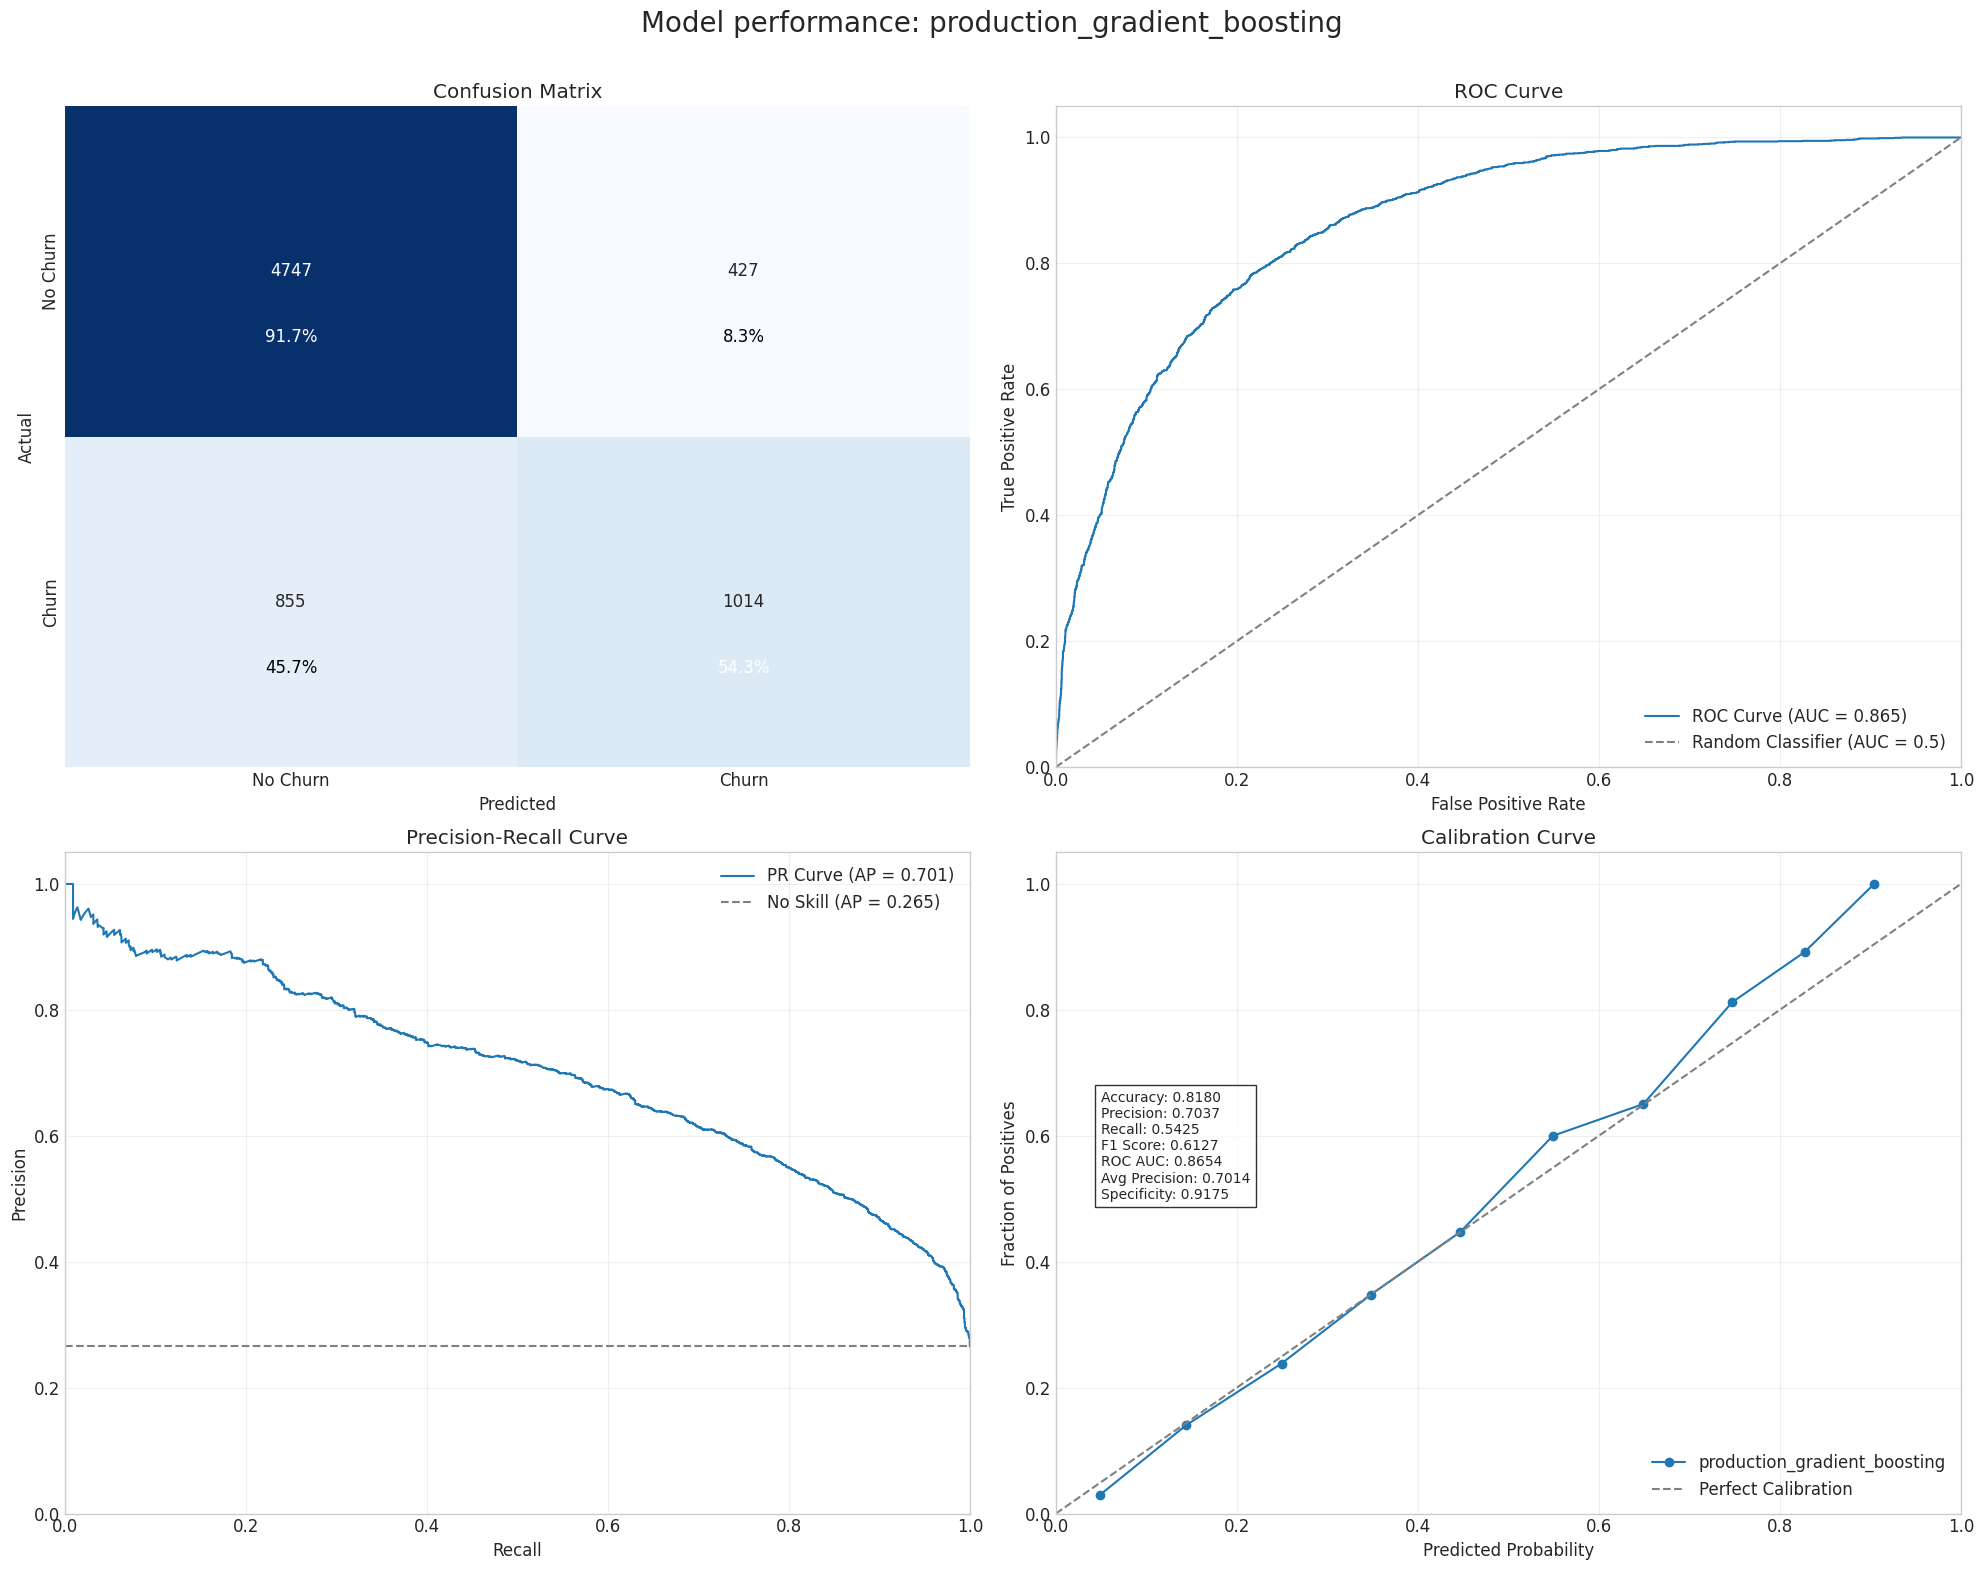

Evaluation results saved: ../models/evaluation/production_gradient_boosting_evaluation.json


In [148]:
evaluation_results = {}

for model_name, model in primary_models.items():
    print(f"Evaluating {model_name}")

    results = evaluate_model_performance(model, X, y, model_name)
    evaluation_results[model_name] = results

    print(f"  Accuracy: {results['accuracy']:.4f}")
    print(f"  Precision: {results['precision']:.4f}")
    print(f"  Recall: {results['recall']:.4f}")
    print(f"  F1 Score: {results['f1_score']:.4f}")
    print(f"  ROC AUC: {results['roc_auc']:.4f}")
    print(f"  Average precision: {results['average_precision']:.4f}")
    print(f"  Log loss: {results['log_loss']:.4f}")
    print(f"  Evaluation completed in: {results['eval_time']:.4f}")

    plot_model_performance(results, model_name)
    save_evaluation_result(results, model_name)

Summary DataFrame for all results


In [149]:
metrics_df = pd.DataFrame(
    [
        {
            "Model": model_name,
            "Accuracy": results["accuracy"],
            "Precision": results["precision"],
            "Recall": results["recall"],
            "F1 Score": results["f1_score"],
            "ROC AUC": results["roc_auc"],
            "Avg Precision": results["average_precision"],
            "Log Loss": results["log_loss"],
            "Brier Score": results["brier_score"],
        }
        for model_name, results in evaluation_results.items()
    ]
)

In [150]:
display(metrics_df.sort_values("ROC AUC", ascending=False).T)

,0
Model,production_gradient_boosting
Accuracy,0.817975
Precision,0.703678
Recall,0.542536
F1 Score,0.612689
ROC AUC,0.865376
Avg Precision,0.701356
Log Loss,0.394945
Brier Score,0.126864


In [151]:
metrics_df.to_csv(
    Path(CONFIG["evaluation_path"]) / "model_performance_summary.csv", index=False
)